In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
import dask.dataframe as dd
import pandas as pd
import os

folder_path = '/content/drive/MyDrive/parquet_stations'
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.parquet')]

daily_dfs = []

for file in all_files:
    # Đọc bằng Pandas
    df = pd.read_parquet(file)

    # Drop các cột không cần thiết sớm để tiết kiệm RAM/tính toán
    df = df.drop(columns=['WND_ANGLE', 'WND_RATE', 'SLP', 'MASK', 'TIME_DIFF'], errors='ignore')

    # Chuyển DATE về datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.set_index('DATE')

    # Resample theo ngày: trung bình
    daily_df = df.resample('1D').mean().reset_index()

    # Giữ lại LONGITUDE & LATITUDE của trạm
    if 'LONGITUDE' in df.columns and 'LATITUDE' in df.columns:
        lon = df['LONGITUDE'].iloc[0]
        lat = df['LATITUDE'].iloc[0]
        daily_df['LONGITUDE'] = lon
        daily_df['LATITUDE'] = lat

    daily_dfs.append(daily_df)

# Gộp tất cả lại thành một Dask dataframe
combined_df = dd.from_pandas(pd.concat(daily_dfs, ignore_index=True), npartitions=4)

# Kiểm tra
print(combined_df.head())


        DATE  LONGITUDE   LATITUDE       TMP       DEW
0 2014-01-01  27.183333  60.283333  2.997917  1.397917
1 2014-01-02  27.183333  60.283333  0.483333 -1.475000
2 2014-01-03  27.183333  60.283333  0.991667 -0.804167
3 2014-01-04  27.183333  60.283333  2.212500  1.012500
4 2014-01-05  27.183333  60.283333  4.025000  3.395833


In [ ]:
station_features = combined_df.groupby(['LONGITUDE', 'LATITUDE']).agg({
    'TMP': ['mean', 'std'],
    'DEW': ['mean', 'std'],
}).compute().reset_index()

station_features.columns = ['LONGITUDE', 'LATITUDE', 'TMP_mean', 'TMP_std', 'DEW_mean', 'DEW_std']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = station_features[['TMP_mean', 'TMP_std']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
station_features['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
combined_df = combined_df.merge(station_features[['LONGITUDE', 'LATITUDE', 'cluster']],
                                on=['LONGITUDE', 'LATITUDE'], how='left')

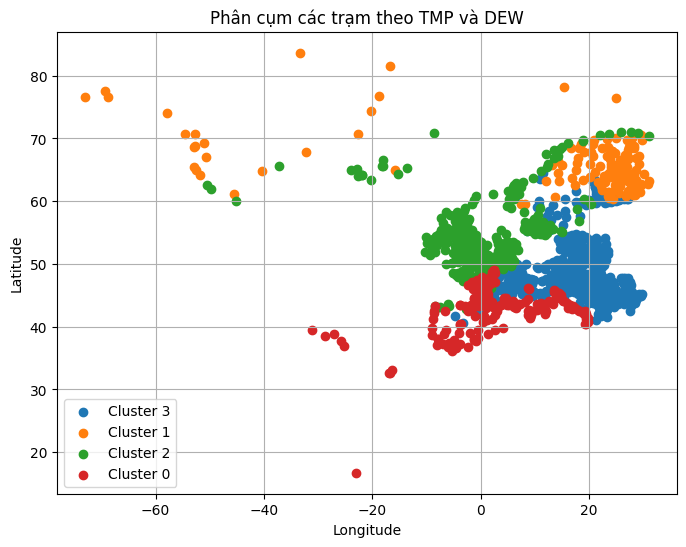

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for c in station_features['cluster'].unique():
    cluster_data = station_features[station_features['cluster'] == c]
    plt.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], label=f'Cluster {c}')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Phân cụm các trạm theo TMP và DEW")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df = combined_df.compute()

In [ ]:
df

,DATE,LONGITUDE,LATITUDE,TMP,DEW,cluster
0,2014-01-01,27.183333,60.283333,2.997917,1.397917,3
1,2014-01-02,27.183333,60.283333,0.483333,-1.475000,3
2,2014-01-03,27.183333,60.283333,0.991667,-0.804167,3
3,2014-01-04,27.183333,60.283333,2.212500,1.012500,3
4,2014-01-05,27.183333,60.283333,4.025000,3.395833,3
...,...,...,...,...,...,...
1095595,2023-12-27,28.144397,61.044553,-11.595833,-12.916667,1
1095596,2023-12-28,28.144397,61.044553,-6.400000,-7.262500,1
1095597,2023-12-29,28.144397,61.044553,-4.283333,-4.950000,1
1095598,2023-12-30,28.144397,61.044553,-7.904167,-9.200000,1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

class TemperaturePredictionModel:
    def __init__(self):
        self.model = LinearRegression()
        self.scaler = StandardScaler()
        self.is_trained = False  # Thêm dòng này
        self.feature_names = []

    def create_features(self, df):
        """Tạo các feature từ dữ liệu thời gian và vị trí"""
        df = df.copy()
        df['DATE'] = pd.to_datetime(df['DATE'])

        # Features từ thời gian
        df['year'] = df['DATE'].dt.year
        df['month'] = df['DATE'].dt.month
        df['day_of_year'] = df['DATE'].dt.dayofyear
        df['day_of_month'] = df['DATE'].dt.day

        # Features chu kỳ (sin/cos để capture tính tuần hoàn)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

        # Features vị trí
        df['lat_lon_interaction'] = df['LATITUDE'] * df['LONGITUDE']
        df['distance_from_equator'] = np.abs(df['LATITUDE'])

        # Sắp xếp theo thời gian để tạo lag features
        df = df.sort_values(['LONGITUDE', 'LATITUDE', 'DATE'])

        df_dew_available = df.dropna(subset=['DEW']).copy()

        if not df_dew_available.empty:
            # Tính trung bình DEW theo Longitude, Latitude, và Day of Year
            # Sử dụng .reset_index() để chuyển groupby keys thành cột
            seasonal_dew_avg = df_dew_available.groupby(['LONGITUDE', 'LATITUDE', 'day_of_year'])['DEW'].mean().reset_index()
            seasonal_dew_avg.rename(columns={'DEW': 'seasonal_dew_avg'}, inplace=True)

            # 2. Merge giá trị DEW trung bình theo mùa vào DataFrame gốc
            # Merge dựa trên Longitude, Latitude, và Day of Year
            df = df.merge(seasonal_dew_avg, on=['LONGITUDE', 'LATITUDE', 'day_of_year'], how='left')

            # 3. Điền các giá trị NaN trong cột DEW gốc bằng giá trị seasonal_dew_avg
            # Chỉ điền cho những hàng mà DEW ban đầu là NaN
            df['DEW'] = df['DEW'].fillna(df['seasonal_dew_avg'])

            # Xóa cột trung gian seasonal_dew_avg
            df = df.drop(columns=['seasonal_dew_avg'])

        # Lag features (nhiệt độ ngày trước)
        df['temp_lag_1'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].shift(1)
        df['temp_lag_7'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].shift(7)
        df['temp_lag_30'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].shift(30)

        # Moving averages - cách an toàn hơn
        df['temp_ma_7'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
        df['temp_ma_30'] = df.groupby(['LONGITUDE', 'LATITUDE'])['TMP'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

        df['DEW_lag_year'] = df.groupby(['LONGITUDE', 'LATITUDE'])['DEW'].shift(365) # Sử dụng DEW đã fillna theo mùa

        # Trend feature (số ngày từ ngày đầu tiên)
        df['days_from_start'] = (df['DATE'] - df['DATE'].min()).dt.days

        return df

    def prepare_data(self, df):
        """Chuẩn bị dữ liệu cho training"""
        df_features = self.create_features(df)

        # Chọn features cho model
        feature_cols = [
            'LONGITUDE', 'LATITUDE',
            'DEW',
            'DEW_lag_year',
            'cluster',
            'year', 'month', 'day_of_year', 'day_of_month',
            'month_sin', 'month_cos', 'day_sin', 'day_cos',
            'lat_lon_interaction', 'distance_from_equator',
            'temp_lag_1', 'temp_lag_7', 'temp_lag_30',
            'temp_ma_7', 'temp_ma_30', 'days_from_start'
        ]

        self.feature_names = feature_cols

        # Loại bỏ rows có NaN (do lag features)
        df_clean = df_features.dropna(subset=self.feature_names + ['TMP'])

        X = df_clean[feature_cols]
        y = df_clean['TMP']

        return X, y, df_clean

    def train(self, df, test_size=0.2):
        """Training model"""
        print("Đang chuẩn bị dữ liệu...")
        X, y, df_clean = self.prepare_data(df)

        print(f"Số lượng samples sau khi làm sạch: {len(X)}")
        print(f"Features được sử dụng: {len(self.feature_names)}")

        # Chia train/test theo thời gian (test set là dữ liệu gần đây nhất)
        df_clean = df_clean.sort_values('DATE')
        split_idx = int(len(df_clean) * (1 - test_size))

        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y.iloc[:split_idx]
        y_test = y.iloc[split_idx:]

        print("Đang training model...")

        # Chuẩn hóa dữ liệu
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Training
        self.model.fit(X_train_scaled, y_train)

        # Đánh giá
        train_pred = self.model.predict(X_train_scaled)
        test_pred = self.model.predict(X_test_scaled)

        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)

        print(f"\n=== KẾT QUẢ TRAINING ===")
        print(f"Train MAE: {train_mae:.3f}°C")
        print(f"Test MAE: {test_mae:.3f}°C")
        print(f"Train R²: {train_r2:.3f}")
        print(f"Test R²: {test_r2:.3f}")

        self.is_trained = True # Set True sau khi train

        return {
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2
        }

    def predict(self, df):
        """Dự đoán nhiệt độ"""
        if not self.is_trained:
            raise ValueError("Model chưa được training!")

        df_features = self.create_features(df)
        X = df_features[self.feature_names]

        # Handle missing values bằng cách fill
        # Sử dụng fillna(method='ffill').fillna(method='bfill') trước khi fillna(0)
        # để giữ lại các giá trị lân cận nếu có
        X = X.fillna(method='ffill').fillna(method='bfill')
        X = X.fillna(0) # Fill remaining NaNs, e.g., at the beginning of series


        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)

        return predictions

    def save_model(self, filepath):
        """Lưu model"""
        if not self.is_trained:
            raise ValueError("Model chưa được training!")

        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'is_trained': self.is_trained
        }
        joblib.dump(model_data, filepath)
        print(f"Model đã được lưu tại: {filepath}")

    def load_model(self, filepath):
        """Load model"""
        model_data = joblib.load(filepath)
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.feature_names = model_data['feature_names']
        self.is_trained = model_data['is_trained'] # Load lại trạng thái is_trained
        print(f"Model đã được load từ: {filepath}")

    def predict_single(self, longitude, latitude, date, dew, cluster):
        """Dự đoán cho một điểm dữ liệu đơn lẻ"""
        # Tạo DataFrame từ input
        df_single = pd.DataFrame({
            'DATE': [pd.to_datetime(date)],
            'LONGITUDE': [longitude],
            'LATITUDE': [latitude],
            'DEW': [dew],
            'cluster': [cluster],
            'TMP': [0]  # Dummy value
        })

        try:
            # Sử dụng phương thức predict chung, nó sẽ xử lý feature engineering và scaling
            prediction = self.predict(df_single)
            return prediction[0]
        except Exception as e:
            print(f"Lỗi khi dự đoán điểm đơn lẻ bằng model đã train: {e}")
            # Fallback: dự đoán đơn giản dựa trên DEW và vị trí (như ban đầu)
            print("Thực hiện dự đoán đơn giản làm fallback...")
            base_temp = dew + 5  # Rough estimate
            date_obj = pd.to_datetime(date)
            seasonal_factor = np.sin(2 * np.pi * date_obj.dayofyear / 365) * 10
            lat_factor = -abs(latitude * 0.5)
            return base_temp + seasonal_factor + lat_factor
def create_evaluator_from_trained_model(model, df, test_ratio=0.2):
    """Tạo evaluator từ model đã được train"""

    # Recreate the data processing
    df_features = model.create_features(df)
    feature_cols = model.feature_names # Lấy feature_names đã cập nhật từ model

    df_clean = df_features.dropna(subset=[f for f in feature_cols + ['TMP'] if f in df_features.columns])
    X = df_clean[feature_cols]
    y = df_clean['TMP']

    # Split data
    df_clean = df_clean.sort_values('DATE')
    split_idx = int(len(df_clean) * (1 - test_ratio))

    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    # Scale data
    X_train_scaled = model.scaler.transform(X_train) # Sử dụng scaler đã fit trong model
    X_test_scaled = model.scaler.transform(X_test)

    # Create evaluator
    evaluator = ModelEvaluator(
        model.model, X_train_scaled, X_test_scaled,
        y_train, y_test, feature_cols # Truyền feature_cols đã cập nhật
    )

    return evaluator, df_clean.iloc[split_idx:]

# Ví dụ sử dụng
def demo_usage():
    """Ví dụ cách sử dụng model"""
    # Training model
    print("\n=== TRAINING MODEL ===")
    model = TemperaturePredictionModel()
    results = model.train(df)

    # Lưu model
    model.save_model('temperature_model.pkl')

    return model

if __name__ == "__main__":
    # Chạy demo
    model = demo_usage()


=== TRAINING MODEL ===
Đang chuẩn bị dữ liệu...
Số lượng samples sau khi làm sạch: 3944765
Features được sử dụng: 21
Đang training model...

=== KẾT QUẢ TRAINING ===
Train MAE: 1.346°C
Test MAE: 1.536°C
Train R²: 0.949
Test R²: 0.958
Model đã được lưu tại: temperature_model.pkl


Model đã được load từ: temperature_model.pkl
Bắt đầu đánh giá toàn diện...
           BÁOCÁO ĐÁNH GIÁ HIỆU SUẤT MODEL

📊 METRICS TỔNG QUAN:
----------------------------------------
Metric          Train        Test         Diff        
----------------------------------------
MAE (°C)        3.095        2.741        0.354       
RMSE (°C)       3.592        3.204        0.388       
R² Score        0.782        0.831        0.049       

=== KẾT QUẢ ĐÁNH GIÁ ===
Train MSE: 12.903
Test MSE: 10.264
Train RMSE: 3.592
Test RMSE: 3.204

🎯 ĐÁNH GIÁ CHẤT LƯỢNG:
----------------------------------------
Độ chính xác (MAE): Tốt ⭐⭐⭐⭐
Khả năng giải thích (R²): Tốt ⭐⭐⭐⭐
Tình trạng overfitting: Không overfitting ✅

📈 PHÂN TÍCH CHI TIẾT:
----------------------------------------
• Lỗi trung bình: 2.74°C
• 95% dự đoán trong khoảng: ±6.28°C
• Model giải thích được 83.1% biến thiên nhiệt độ
• 90% dự đoán có lỗi ≤ 4.95°C
• 50% dự đoán có lỗi ≤ 2.55°C

💡 KHUYẾN NGHỊ:
--------------------------------------

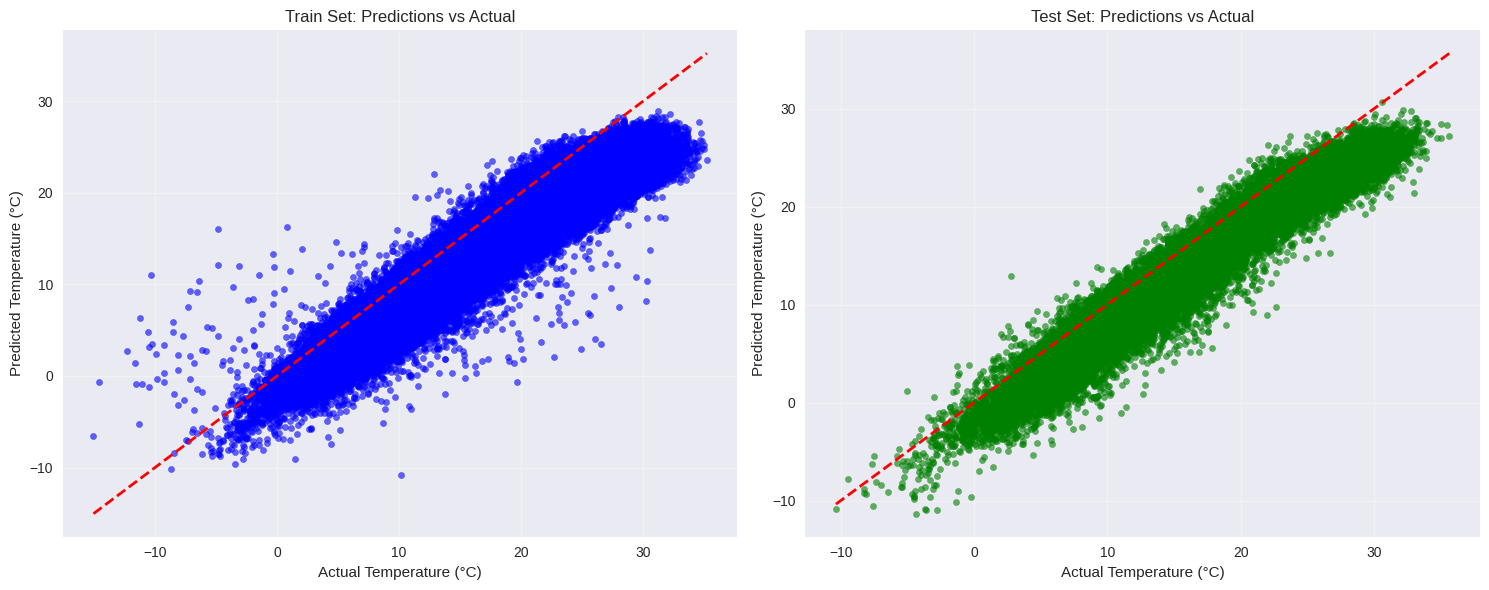

2. Vẽ biểu đồ Residuals...


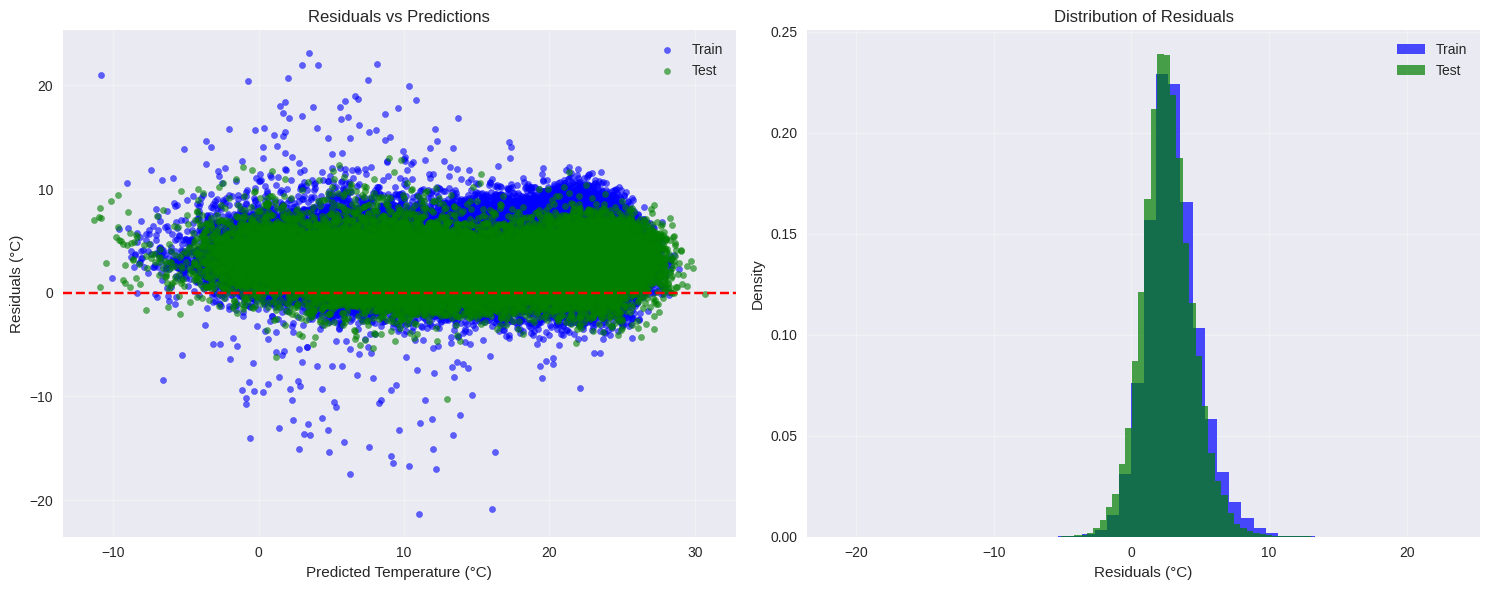

3. Vẽ biểu đồ Feature Importance...


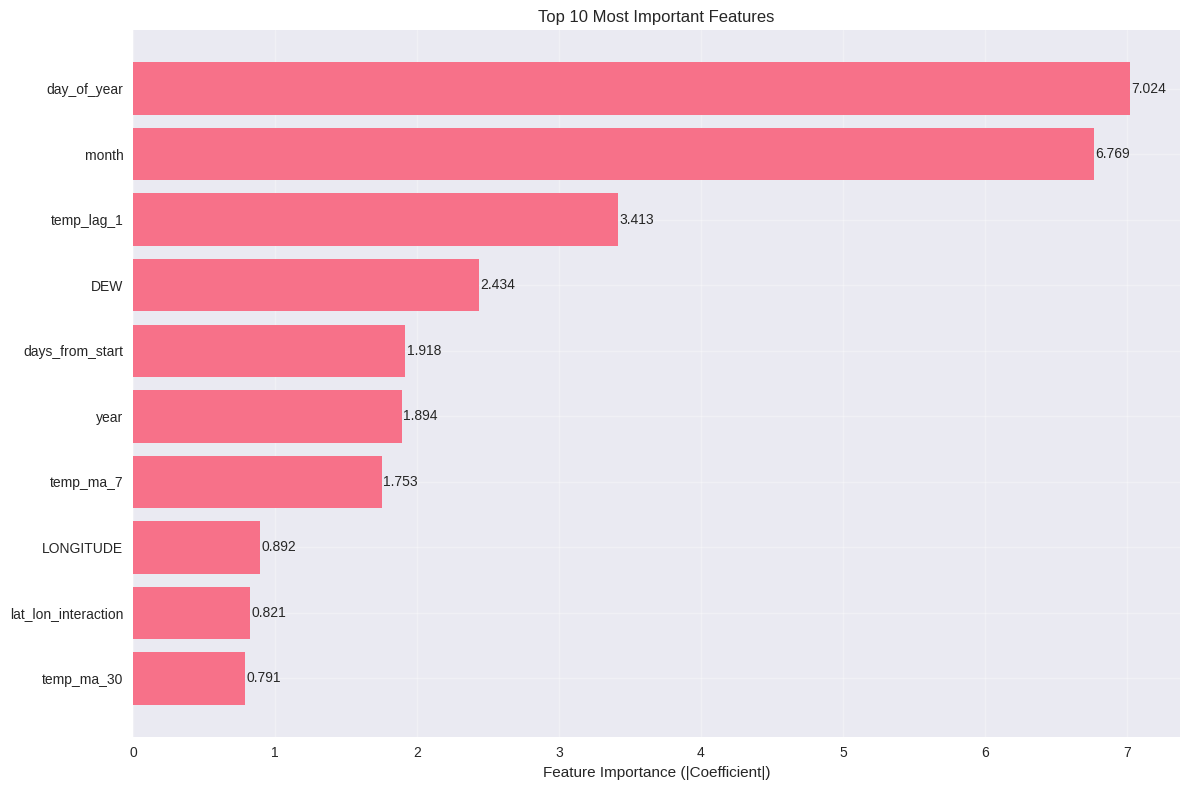


✅ Hoàn thành đánh giá!
=== VÍ DỤ ĐÁNH GIÁ MODEL ===


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ModelEvaluator:
    """Công cụ đánh giá và trực quan hóa hiệu suất model"""

    def __init__(self, model, X_train, X_test, y_train, y_test, feature_names):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = feature_names

        # Predictions
        self.y_train_pred = model.predict(X_train)
        self.y_test_pred = model.predict(X_test)

    def calculate_metrics(self):
        """Tính toán các metrics đánh giá"""
        metrics = {}

        # Train metrics
        metrics['train_mae'] = mean_absolute_error(self.y_train, self.y_train_pred)
        metrics['train_mse'] = mean_squared_error(self.y_train, self.y_train_pred)
        metrics['train_rmse'] = np.sqrt(metrics['train_mse'])
        metrics['train_r2'] = r2_score(self.y_train, self.y_train_pred)
        metrics['train_mape'] = mean_absolute_percentage_error(self.y_train, self.y_train_pred)

        # Test metrics
        metrics['test_mae'] = mean_absolute_error(self.y_test, self.y_test_pred)
        metrics['test_mse'] = mean_squared_error(self.y_test, self.y_test_pred)
        metrics['test_rmse'] = np.sqrt(metrics['test_mse'])
        metrics['test_r2'] = r2_score(self.y_test, self.y_test_pred)
        metrics['test_mape'] = mean_absolute_percentage_error(self.y_test, self.y_test_pred)

        return metrics

    def plot_predictions_vs_actual(self, figsize=(15, 6)):
        """Biểu đồ so sánh predictions vs actual"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Train set
        ax1.scatter(self.y_train, self.y_train_pred, alpha=0.6, color='blue', s=20)
        ax1.plot([self.y_train.min(), self.y_train.max()],
                [self.y_train.min(), self.y_train.max()], 'r--', lw=2)
        ax1.set_xlabel('Actual Temperature (°C)')
        ax1.set_ylabel('Predicted Temperature (°C)')
        ax1.set_title('Train Set: Predictions vs Actual')
        ax1.grid(True, alpha=0.3)

        # Test set
        ax2.scatter(self.y_test, self.y_test_pred, alpha=0.6, color='green', s=20)
        ax2.plot([self.y_test.min(), self.y_test.max()],
                [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        ax2.set_xlabel('Actual Temperature (°C)')
        ax2.set_ylabel('Predicted Temperature (°C)')
        ax2.set_title('Test Set: Predictions vs Actual')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_residuals(self, figsize=(15, 6)):
        """Biểu đồ residuals để kiểm tra pattern"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Residuals vs Predictions
        train_residuals = self.y_train - self.y_train_pred
        test_residuals = self.y_test - self.y_test_pred

        ax1.scatter(self.y_train_pred, train_residuals, alpha=0.6, color='blue', s=20, label='Train')
        ax1.scatter(self.y_test_pred, test_residuals, alpha=0.6, color='green', s=20, label='Test')
        ax1.axhline(y=0, color='r', linestyle='--')
        ax1.set_xlabel('Predicted Temperature (°C)')
        ax1.set_ylabel('Residuals (°C)')
        ax1.set_title('Residuals vs Predictions')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Histogram of residuals
        ax2.hist(train_residuals, bins=50, alpha=0.7, color='blue', label='Train', density=True)
        ax2.hist(test_residuals, bins=50, alpha=0.7, color='green', label='Test', density=True)
        ax2.set_xlabel('Residuals (°C)')
        ax2.set_ylabel('Density')
        ax2.set_title('Distribution of Residuals')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, top_n=10, figsize=(12, 8)):
        """Biểu đồ feature importance"""
        if hasattr(self.model, 'coef_'):
            importance = np.abs(self.model.coef_)
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=figsize)
            top_features = feature_importance.head(top_n)

            bars = plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance (|Coefficient|)')
            plt.title(f'Top {top_n} Most Important Features')
            plt.gca().invert_yaxis()

            # Add value labels on bars
            for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
                plt.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{val:.3f}', va='center', fontsize=10)

            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            return feature_importance
        else:
            print("Model không có feature importance (coef_)")
            return None

    def plot_error_analysis(self, figsize=(15, 10)):
        """Phân tích lỗi chi tiết"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

        # Error by temperature range
        test_errors = np.abs(self.y_test - self.y_test_pred)
        temp_ranges = pd.cut(self.y_test, bins=10)
        error_by_temp = pd.DataFrame({
            'temp_range': temp_ranges,
            'error': test_errors
        }).groupby('temp_range')['error'].mean()

        ax1.bar(range(len(error_by_temp)), error_by_temp.values)
        ax1.set_xticks(range(len(error_by_temp)))
        ax1.set_xticklabels([f'{i.left:.1f}-{i.right:.1f}' for i in error_by_temp.index], rotation=45)
        ax1.set_ylabel('Mean Absolute Error (°C)')
        ax1.set_title('Error by Temperature Range')
        ax1.grid(True, alpha=0.3)

        # Error distribution
        ax2.boxplot([np.abs(self.y_train - self.y_train_pred),
                    np.abs(self.y_test - self.y_test_pred)],
                   labels=['Train', 'Test'])
        ax2.set_ylabel('Absolute Error (°C)')
        ax2.set_title('Error Distribution')
        ax2.grid(True, alpha=0.3)

        # Cumulative error
        test_errors_sorted = np.sort(test_errors)
        cumulative_pct = np.arange(1, len(test_errors_sorted) + 1) / len(test_errors_sorted) * 100
        ax3.plot(test_errors_sorted, cumulative_pct)
        ax3.set_xlabel('Absolute Error (°C)')
        ax3.set_ylabel('Cumulative Percentage (%)')
        ax3.set_title('Cumulative Error Distribution')
        ax3.grid(True, alpha=0.3)

        # Error vs actual temperature
        ax4.scatter(self.y_test, test_errors, alpha=0.6, s=20)
        ax4.set_xlabel('Actual Temperature (°C)')
        ax4.set_ylabel('Absolute Error (°C)')
        ax4.set_title('Error vs Actual Temperature')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_time_series_sample(self, df_test, sample_stations=3, figsize=(15, 8)):
        """Biểu đồ time series cho một số trạm mẫu"""
        if 'DATE' not in df_test.columns:
            print("Cần có column DATE để vẽ time series")
            return

        # Lấy một số trạm mẫu
        unique_stations = df_test.groupby(['LONGITUDE', 'LATITUDE']).size().head(sample_stations).index

        fig, axes = plt.subplots(sample_stations, 1, figsize=figsize)
        if sample_stations == 1:
            axes = [axes]

        for i, (lon, lat) in enumerate(unique_stations):
            station_data = df_test[(df_test['LONGITUDE'] == lon) & (df_test['LATITUDE'] == lat)].copy()
            station_data = station_data.sort_values('DATE')

            if len(station_data) > 0:
                axes[i].plot(station_data['DATE'], station_data['TMP'],
                           label='Actual', linewidth=2, alpha=0.8)

                # Nếu có predictions trong data
                if 'TMP_PRED' in station_data.columns:
                    axes[i].plot(station_data['DATE'], station_data['TMP_PRED'],
                               label='Predicted', linewidth=2, alpha=0.8)

                axes[i].set_title(f'Station ({lon:.2f}, {lat:.2f})')
                axes[i].set_ylabel('Temperature (°C)')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_report(self):
        """Tạo báo cáo tổng quan"""
        metrics = self.calculate_metrics()

        print("="*60)
        print("           BÁOCÁO ĐÁNH GIÁ HIỆU SUẤT MODEL")
        print("="*60)

        print(f"\n📊 METRICS TỔNG QUAN:")
        print("-" * 40)
        print(f"{'Metric':<15} {'Train':<12} {'Test':<12} {'Diff':<12}")
        print("-" * 40)
        print(f"{'MAE (°C)':<15} {metrics['train_mae']:<12.3f} {metrics['test_mae']:<12.3f} {abs(metrics['train_mae'] - metrics['test_mae']):<12.3f}")
        print(f"{'RMSE (°C)':<15} {metrics['train_rmse']:<12.3f} {metrics['test_rmse']:<12.3f} {abs(metrics['train_rmse'] - metrics['test_rmse']):<12.3f}")
        print(f"{'R² Score':<15} {metrics['train_r2']:<12.3f} {metrics['test_r2']:<12.3f} {abs(metrics['train_r2'] - metrics['test_r2']):<12.3f}")
        print("\n=== KẾT QUẢ ĐÁNH GIÁ ===")
        print(f"Train MSE: {metrics['train_mse']:.3f}")
        print(f"Test MSE: {metrics['test_mse']:.3f}")
        print(f"Train RMSE: {metrics['train_rmse']:.3f}")
        print(f"Test RMSE: {metrics['test_rmse']:.3f}")
        print(f"\n🎯 ĐÁNH GIÁ CHẤT LƯỢNG:")
        print("-" * 40)

        # Đánh giá MAE
        if metrics['test_mae'] <= 2:
            mae_rating = "Xuất sắc ⭐⭐⭐⭐⭐"
        elif metrics['test_mae'] <= 3:
            mae_rating = "Tốt ⭐⭐⭐⭐"
        elif metrics['test_mae'] <= 5:
            mae_rating = "Khá ⭐⭐⭐"
        else:
            mae_rating = "Cần cải thiện ⭐⭐"

        # Đánh giá R²
        if metrics['test_r2'] >= 0.9:
            r2_rating = "Xuất sắc ⭐⭐⭐⭐⭐"
        elif metrics['test_r2'] >= 0.8:
            r2_rating = "Tốt ⭐⭐⭐⭐"
        elif metrics['test_r2'] >= 0.7:
            r2_rating = "Khá ⭐⭐⭐"
        else:
            r2_rating = "Cần cải thiện ⭐⭐"

        # Đánh giá Overfitting
        mae_diff = abs(metrics['train_mae'] - metrics['test_mae'])
        if mae_diff <= 0.5:
            overfit_rating = "Không overfitting ✅"
        elif mae_diff <= 1.0:
            overfit_rating = "Overfitting nhẹ ⚠️"
        else:
            overfit_rating = "Overfitting nghiêm trọng ❌"

        print(f"Độ chính xác (MAE): {mae_rating}")
        print(f"Khả năng giải thích (R²): {r2_rating}")
        print(f"Tình trạng overfitting: {overfit_rating}")

        print(f"\n📈 PHÂN TÍCH CHI TIẾT:")
        print("-" * 40)
        print(f"• Lỗi trung bình: {metrics['test_mae']:.2f}°C")
        print(f"• 95% dự đoán trong khoảng: ±{metrics['test_rmse']*1.96:.2f}°C")
        print(f"• Model giải thích được {metrics['test_r2']*100:.1f}% biến thiên nhiệt độ")

        # Error percentiles
        test_errors = np.abs(self.y_test - self.y_test_pred)
        print(f"• 90% dự đoán có lỗi ≤ {np.percentile(test_errors, 90):.2f}°C")
        print(f"• 50% dự đoán có lỗi ≤ {np.percentile(test_errors, 50):.2f}°C")

        print(f"\n💡 KHUYẾN NGHỊ:")
        print("-" * 40)
        if metrics['test_mae'] > 3:
            print("• Nên thêm feature engineering hoặc dùng model phức tạp hơn")
        if mae_diff > 1:
            print("• Nên thêm regularization để giảm overfitting")
        if metrics['test_r2'] < 0.8:
            print("• Nên kiểm tra và làm sạch dữ liệu outliers")
        if metrics['test_mae'] <= 2 and metrics['test_r2'] >= 0.85:
            print("• Model đạt chất lượng tốt, sẵn sàng production! 🚀")

        return metrics

    def comprehensive_evaluation(self, df_test=None):
        """Đánh giá toàn diện với tất cả biểu đồ"""
        print("Bắt đầu đánh giá toàn diện...")

        # 1. Báo cáo metrics
        metrics = self.generate_report()

        # 2. Biểu đồ predictions vs actual
        print("\n1. Vẽ biểu đồ Predictions vs Actual...")
        self.plot_predictions_vs_actual()

        # 3. Biểu đồ residuals
        print("2. Vẽ biểu đồ Residuals...")
        self.plot_residuals()

        # 4. Feature importance
        print("3. Vẽ biểu đồ Feature Importance...")
        feature_imp = self.plot_feature_importance()

        print("\n✅ Hoàn thành đánh giá!")
        return metrics, feature_imp

# Hàm tạo evaluator từ model đã train
def create_evaluator_from_trained_model(model, df, test_ratio=0.2):
    """Tạo evaluator từ model đã được train"""

    # Recreate the data processing
    df_features = model.create_features(df)
    feature_cols = model.feature_names

    df_clean = df_features.dropna(subset=feature_cols + ['TMP'])
    X = df_clean[feature_cols]
    y = df_clean['TMP']

    # Split data
    df_clean = df_clean.sort_values('DATE')
    split_idx = int(len(df_clean) * (1 - test_ratio))

    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    # Scale data
    X_train_scaled = model.scaler.transform(X_train)
    X_test_scaled = model.scaler.transform(X_test)

    # Create evaluator
    evaluator = ModelEvaluator(
        model.model, X_train_scaled, X_test_scaled,
        y_train, y_test, feature_cols
    )

    return evaluator, df_clean.iloc[split_idx:]

# Ví dụ sử dụng
def example_usage():
    """Ví dụ cách sử dụng với model đã train"""

    print("=== VÍ DỤ ĐÁNH GIÁ MODEL ===")

# 1. Load model và data
model = TemperaturePredictionModel()
model.load_model('temperature_model.pkl')
df = pd.read_parquet('/content/drive/MyDrive/clustered_parquet/cluster_19.parquet')

# 2. Tạo evaluator
evaluator, df_test = create_evaluator_from_trained_model(model, df)

# 3. Đánh giá toàn diện - sẽ tạo ra tất cả biểu đồ!
metrics, feature_importance = evaluator.comprehensive_evaluation(df_test)

if __name__ == "__main__":
    example_usage()

In [ ]:
df

,DATE,LONGITUDE,LATITUDE,TMP,DEW,cluster
566060,2014-01-01,4.900000,43.900000,9.725000,4.620833,19
566061,2014-01-02,4.900000,43.900000,11.216667,8.804167,19
566062,2014-01-03,4.900000,43.900000,11.008333,8.150000,19
566063,2014-01-04,4.900000,43.900000,12.029167,9.645833,19
566064,2014-01-05,4.900000,43.900000,8.616667,1.829167,19
...,...,...,...,...,...,...
365195,2023-12-27,12.064156,42.430183,9.853080,6.945892,19
365196,2023-12-28,12.064156,42.430183,9.312500,7.307292,19
365197,2023-12-29,12.064156,42.430183,9.920833,8.040625,19
365198,2023-12-30,12.064156,42.430183,10.770833,8.415625,19


In [ ]:
output_path = '/content/drive/MyDrive/output_df.csv'

df.to_csv(output_path, index=False)

print(f"DataFrame đã được lưu về {output_path}")

DataFrame đã được lưu về /content/drive/MyDrive/output_df.csv


Model đã được load từ: temperature_model.pkl
Đang dự đoán trên DataFrame mới...
Dự đoán đã được thêm vào DataFrame.
             DATE  LONGITUDE  LATITUDE        TMP       DEW  cluster  \
566060 2014-01-01        4.9      43.9   9.725000  4.620833       19   
566061 2014-01-02        4.9      43.9  11.216667  8.804167       19   
566062 2014-01-03        4.9      43.9  11.008333  8.150000       19   
566063 2014-01-04        4.9      43.9  12.029167  9.645833       19   
566064 2014-01-05        4.9      43.9   8.616667  1.829167       19   

        TMP_PREDICTED  
566060       8.978196  
566061      11.115392  
566062      12.249765  
566063      10.791051  
566064       9.219758  


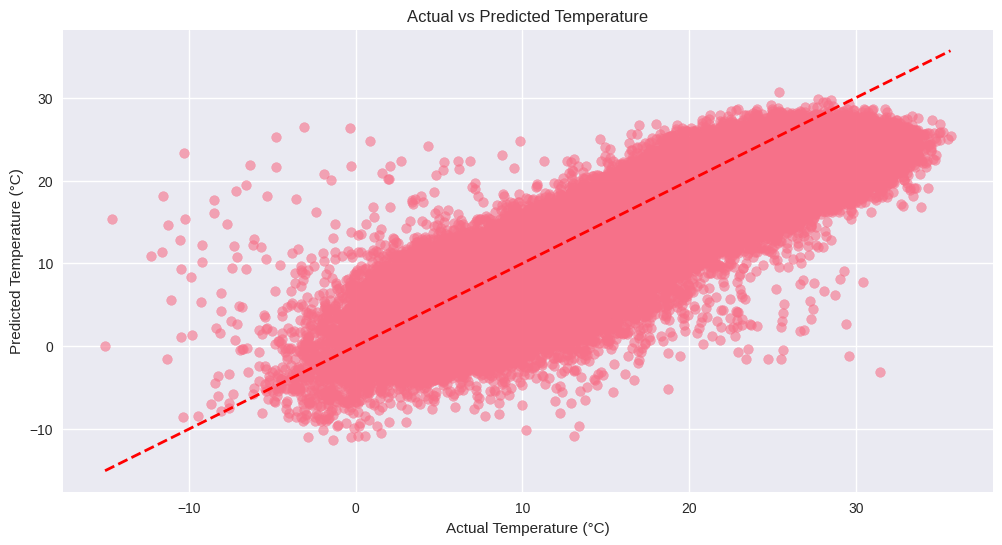

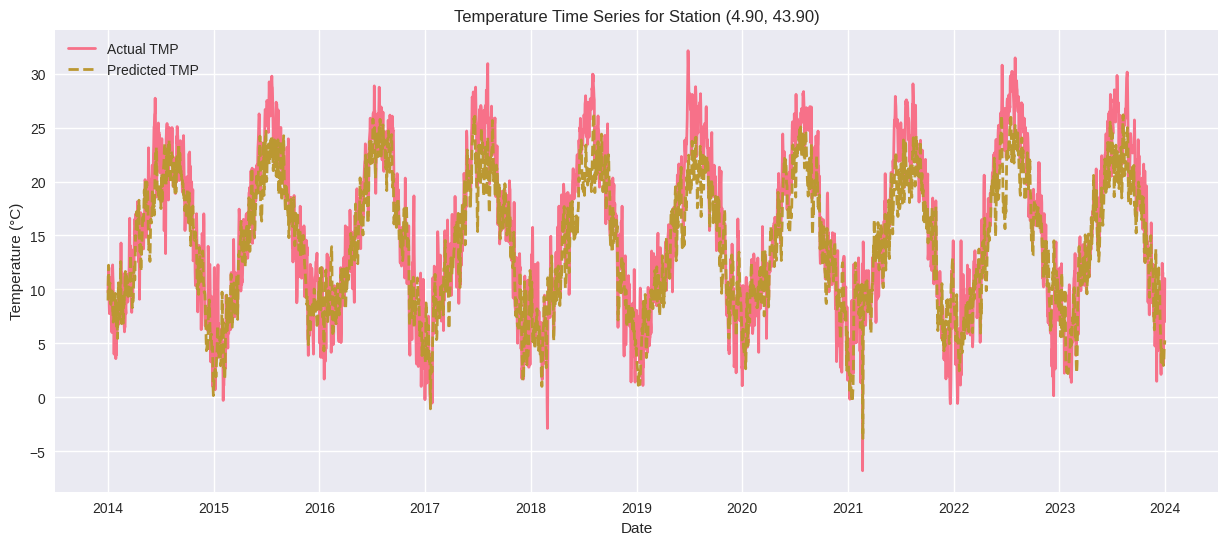

In [ ]:
model = TemperaturePredictionModel()
model.load_model('temperature_model.pkl')

# Giả sử bạn có một DataFrame mới muốn dự đoán
# Ví dụ: dùng lại DataFrame df ban đầu, hoặc load từ một nguồn khác
df_to_predict = df.copy() # Sử dụng df đã có trong notebook làm ví dụ

# Đảm bảo các cột cần thiết cho create_features có mặt
# 'DATE', 'LONGITUDE', 'LATITUDE', 'DEW', 'cluster'

print("Đang dự đoán trên DataFrame mới...")

# Sử dụng phương thức predict của model
# Phương thức này đã bao gồm bước tạo features và scaling
predictions = model.predict(df_to_predict)

# Thêm cột dự đoán vào DataFrame ban đầu hoặc DataFrame mới
df_to_predict['TMP_PREDICTED'] = predictions

print("Dự đoán đã được thêm vào DataFrame.")
print(df_to_predict.head())

# --- Vẽ biểu đồ so sánh (ví dụ) ---
# Nếu df_to_predict chứa cả giá trị TMP thực tế, bạn có thể so sánh
if 'TMP' in df_to_predict.columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(df_to_predict['TMP'], df_to_predict['TMP_PREDICTED'], alpha=0.6)
    plt.plot([df_to_predict['TMP'].min(), df_to_predict['TMP'].max()],
             [df_to_predict['TMP'].min(), df_to_predict['TMP'].max()], 'r--', lw=2) # Đường y=x lý tưởng
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Actual vs Predicted Temperature')
    plt.grid(True)
    plt.show()
else:
    print("DataFrame không có cột 'TMP' thực tế để so sánh.")

# Nếu bạn muốn xem time series của dự đoán cho một trạm cụ thể
# Chọn một trạm mẫu (ví dụ trạm đầu tiên trong df_to_predict)
if not df_to_predict.empty:
    sample_station_coords = df_to_predict[['LONGITUDE', 'LATITUDE']].iloc[0].tolist()
    lon_sample, lat_sample = sample_station_coords

    station_data = df_to_predict[(df_to_predict['LONGITUDE'] == lon_sample) &
                                 (df_to_predict['LATITUDE'] == lat_sample)].copy()
    station_data = station_data.sort_values('DATE')

    if len(station_data) > 0:
        plt.figure(figsize=(15, 6))
        if 'TMP' in station_data.columns:
             plt.plot(station_data['DATE'], station_data['TMP'], label='Actual TMP', linewidth=2)
        plt.plot(station_data['DATE'], station_data['TMP_PREDICTED'], label='Predicted TMP', linewidth=2, linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Temperature (°C)')
        plt.title(f'Temperature Time Series for Station ({lon_sample:.2f}, {lat_sample:.2f})')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Không tìm thấy dữ liệu cho trạm mẫu để vẽ time series.")

In [ ]:
station_features[['LONGITUDE', 'LATITUDE', 'cluster']].drop_duplicates().dropna(subset=['LONGITUDE', 'LATITUDE']).to_csv('station_data.csv', index=False)